In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions import *
import time

In [2]:
start_time = time.time()

In [3]:
# Global parameters of the system
L=4.48
dim=3

In [4]:
# Input (temperature of the systema and density)
T=(119.8/2) # in Kelvin!
cell_parameter_integer =3

a=L/cell_parameter_integer # has to be L/integer, a is cell length (cell parameter)
N=4*(cell_parameter_integer**dim) # has to be 4*(L/a)**dim to fulfill fcc paricles per cell, to reduce - increase density
                                  # of the system increase or lower the integer that modifies cell parameter a

In [5]:
# We obtain the actual number of particles we have
#print("T_real =", T*119.8)
print("N =", N)
print(a)
print("Particle density rho_N =", 4*((cell_parameter_integer/L)**dim))

N = 108
1.4933333333333334
Particle density rho_N = 1.201129168185131


In [6]:
# We initialize the positions and velocities of the particle ensemble
pos0, vel0 = initialization_fcc(N,L,a,T,dim)

In [7]:
# We rescale the energy of the particles with parameters:
loopnum_r=300
h=0.01 # timestep
precision=0.005 #abs(lamda-1) < precision is the precision cosntanint, with lamda the rescaling factor

In [8]:
kin, pot, tot, n_rescales, positions, velocities, kTfin = energy_rescale(N, dim, L, T, pos0, vel0, h, loopnum_r, precision)

print("RESCALING --- %s seconds ---" % (time.time() - start_time))

RESCALING --- 460.67424488067627 seconds ---


In [9]:
length=(n_rescales+1)*(loopnum_r+1)
print(len(kin), length)

2408 2408


In [10]:
print("number of rescales = ", n_rescales)
print("real T we aim (in Kelvin) = ", kTfin*119.8)

number of rescales =  7
real T we aim (in Kelvin) =  59.38351250875992


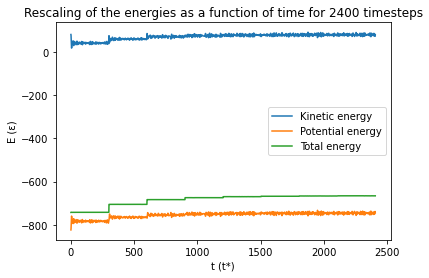

In [11]:
# We plot the reescaling in order to see how the energy behaves
plt.plot(np.linspace(0,length,length),kin, label = 'Kinetic energy')
plt.plot(np.linspace(0,length,length),pot, label = 'Potential energy')
plt.plot(np.linspace(0,length,length),tot, label = 'Total energy')
plt.title(f'Rescaling of the energies as a function of time for {loopnum_r*(n_rescales+1)} timesteps')
plt.xlabel('t (t*)')
plt.ylabel('E (ε)')
plt.legend()
plt.show()

In [12]:
# Now that the system is rescaled and we have the final positions and velocities we will let the system evolve
# to obtain the thermodynamical values
# We compute, for example, the pressure of the system with parameters:

loopnum=20000
h=0.01
bins=100 # this is the number of datapoints we want for the pair correlation function

In [13]:
# We call the merge function, which give us an array made of of 'instantaneous' useful measurements
pb_array, Nr_tracker, total_system, kin_system, potential_system, pos, vel = merge(N, dim, L, positions, velocities, h, loopnum, bins)
print("VERLET EVOLUTION --- %s seconds ---" % (time.time() - start_time))

VERLET EVOLUTION --- 5021.706052064896 seconds ---


In [14]:
# And we transform the arrays of measurements into the observables (pressure, pair correlation function and
# specific heat per atom)
"""
NOTE: We do not really need to do this in the end, the autocorrelation function computes the mean. What we will need to do
is the transformation that will give us the parameter of interest given the ensemble mean value <...> of which it depends
"""
p=(T*N/119.8*(L**3))-(1/(3*(L**3)))*(np.mean(pb_array))

binsize=(L/2)/bins
mean_n = (2*(L**3)/(N*(N+1))*4*np.pi*binsize)*np.sum(Nr_tracker, axis=0)/(loopnum+1)
mean_n = np.delete(mean_n, bins-1)# We  the last number becasue it counts for all particles further than L/2

kin_mean_sq=(np.mean(kin_system, axis=0))**2
kin_sq_mean=np.mean(kin_system**2, axis=0)
rhs=1-((3*N/2)*((kin_sq_mean-kin_mean_sq)/kin_mean_sq))
cv=3/(2*rhs)

In [15]:
# We print the value of the pressure
print(p)

4871.729731658169


pressure=  4871.729731658169
spefific heat per atom=  2.857506805623166


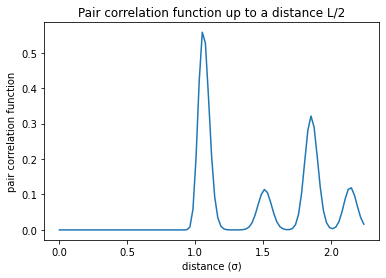

In [16]:
# We print the results
print("pressure= ", p)
print("spefific heat per atom= ", cv)
plt.plot(np.linspace(0, L/2, bins-1), mean_n)
plt.title("Pair correlation function up to a distance L/2")
plt.xlabel('distance (σ)')
plt.ylabel('pair correlation function')
plt.show()

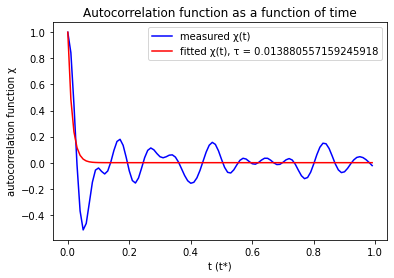

In [17]:
# Finally we want to compute errors of our two observables (since the correlation fucntion
# is not usually presented with errors)
pb, tau_pb, sigma_pb = autocorrelation(pb_array, h)

In [18]:
# We print the results, we can compare with the previous one and see it is the same
print(pb, sigma_pb)

-4396.475221083391 0.7657990291746396


In [19]:
# We recast the <...> value obtained into the observable of interest, in this case the pressure
p=T*N / (119.8 * (L**3)) - pb/(3 * L**3)
sigma_p=sigma_pb/(3*(L**3))
P_SI = p*4.187*10**7
sigma_PSI = sigma_p*4.187*10**7

In [20]:
# We finally print the result
print("p =",p, sigma_p)
print("P_SI =", P_SI, sigma_PSI) # result in international system

p = 16.899128242260566 0.002838961576881221
P_SI = 707566499.5034499 118867.32122401673


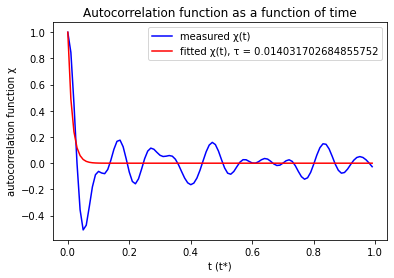

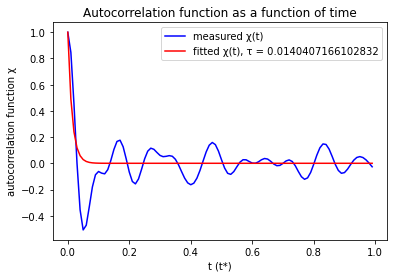

AUTOCORRELATION --- 5028.496618032455 seconds ---


In [21]:
# Now, with the cp we have to compute the error for the total kinetic energy mean value and the total
# kinetic energy squared mean value. To obtain the error in cp we will have to propagate errors
K, tau_K, sigma_K = autocorrelation(kin_system, h)
K2, tau_K2, sigma_K2 = autocorrelation(kin_system**2, h)
print("AUTOCORRELATION --- %s seconds ---" % (time.time() - start_time))

In [22]:
# We print the values and the errors
print(K, K2)
print(sigma_K, sigma_K2)

79.86192336756139 6396.630147823131
0.05122759401733265 8.195578857762074


In [23]:
# We first try to recover temperature
kTsys=2*K/(3*(N-1))
sigma_kTsys=2*np.sqrt(K2-(K**2))/(3*(N-1))

In [24]:
# We print results (success compared to the real value after the rescaling)
print("real T system (in Kelvin) = ", kTsys*119.8, sigma_kTsys*119.8)

real T system (in Kelvin) =  59.61033283136358 3.228058603513216


In [25]:
# We do the corresponding computations
r=1-(3*N/2)*((K2/K**2)-1)
cv=(3/2)*(1/r)
sigma_cv=(3/2)*(1/r**2)*(3*N/2)*((1/K**2)*sigma_K2+(2*K2/(K**3))*sigma_K)

In [26]:
# We finally print the specific heat per atom
print(cv, sigma_cv)

2.8575068056230686 2.267834673350343
